<a href="https://colab.research.google.com/github/vsilchev/hse-time-series/blob/master/Wavelet_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# pyCWT can be also installed via conda install
!pip install pycwt

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pycwt as wavelet
from pycwt.helpers import find

sns.set(style='ticks', palette='Set2')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


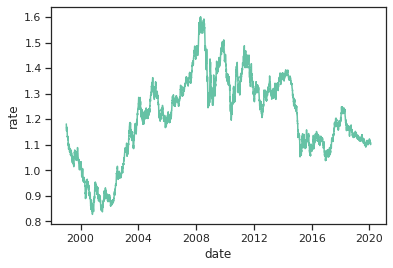

In [2]:
EurUsd_ts = pd.read_csv("https://raw.githubusercontent.com/vsilchev/hse-time-series/master/FRB_H10_EURUSD.csv",
                        parse_dates=['date'],
                        na_values='ND'
                        ).fillna(method='bfill')
sns.lineplot(x='date', y='rate', data=EurUsd_ts)

In [3]:
EurUsd_ts.date.dt.year.value_counts()

2004    262
2008    262
2019    261
2001    261
2007    261
2003    261
2018    261
2014    261
2010    261
2012    261
2002    261
2015    261
2013    261
2009    261
2016    261
2017    260
2005    260
2006    260
1999    260
2011    260
2000    260
2020     23
Name: date, dtype: int64

In [0]:
label = 'Rate'
title = 'EUR/USD Exchange Rate'
dat = EurUsd_ts.rate.values
N = dat.size
t = EurUsd_ts.date.values.astype('float') / (31556926*1e9)+1970 # Float value of year

# Try to detrend the time series...
# p = np.polyfit(t - t[0], dat, 1)
# dat_detrend = dat - np.polyval(p, t - t[0])

# ... or just substract the mean if there is no trend
dat_detrend = dat - np.mean(dat)
std = dat_detrend.std()  # Standard deviation
var = std ** 2  # Variance
dat_norm = dat_detrend / std  # Normalized time series

# dt = (t[-1] - t[0]) / N 
dt = 1 / 261 # time step

In [0]:
mother = wavelet.Morlet(6)
s0 = 2 * dt 
dj = 0.1  # ten sub-octaves per octaves
J = 7 / dj  # Seven powers of two with dj sub-octaves
# alpha, _, _ = wavelet.ar1(dat_norm)  # Lag-1 autocorrelation for red noise

In [0]:
wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(dat_norm, dt, dj, s0, J,
                                                      mother)
iwave = wavelet.icwt(wave, scales, dt, dj, mother) * std

In [0]:
power = (np.abs(wave)) ** 2
power /= scales[:, None]
fft_power = np.abs(fft) ** 2
period = 1 / freqs

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


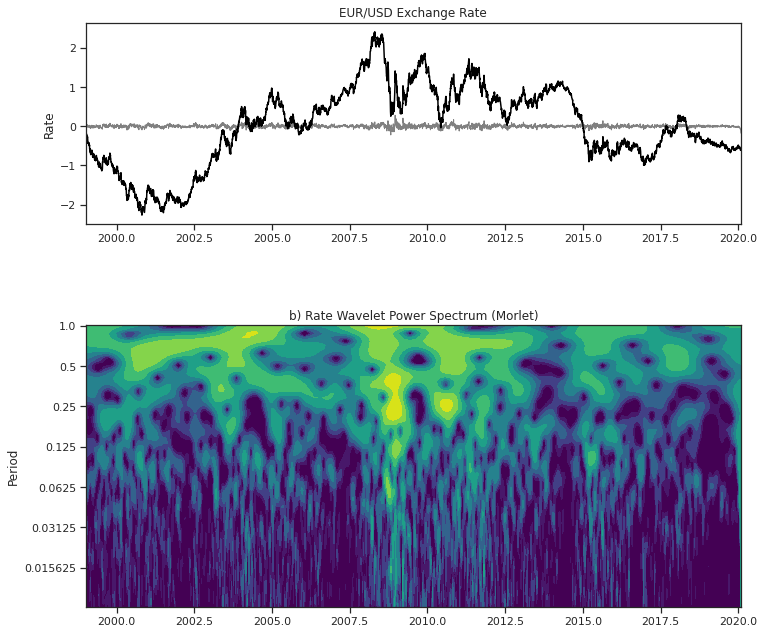

In [8]:
# Prepare the figure
plt.close('all')
plt.ioff()
figprops = dict(figsize=(14, 14))
fig = plt.figure(**figprops)

# First sub-plot, the original time series anomaly and inverse wavelet
# transform.
ax = plt.axes([0.1, 0.75, 0.65, 0.2])
ax.plot(t, iwave, '-', linewidth=1, color=[0.5, 0.5, 0.5])
ax.plot(t, dat_norm, 'k', linewidth=1.5)
ax.set_title('{}'.format(title))
ax.set_ylabel(r'{}'.format(label))

# Second sub-plot, the normalized wavelet power spectrum and significance
# level contour lines and cone of influece hatched area. Note that period
# scale is logarithmic.
bx = plt.axes([0.1, 0.37, 0.65, 0.28], sharex=ax)
levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16]
bx.contourf(t, np.log2(period), np.log2(power), np.log2(levels),
            extend='both', cmap=plt.cm.viridis)

bx.set_title('b) {} Wavelet Power Spectrum ({})'.format(label, mother.name))
bx.set_ylabel('Period')
Yticks = 2 ** np.arange(np.ceil(np.log2(period.min())),
                           np.ceil(np.log2(period.max())))
bx.set_yticks(np.log2(Yticks))
bx.set_yticklabels(Yticks)
#

plt.show()